<a href="https://colab.research.google.com/github/bcwodo/fastai_book/blob/main/K01_Mein_Modell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install duckduckgo_search

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('daisy photos', max_images=5)
urls[0]

Searching for 'daisy photos'


'http://wallsdesk.com/wp-content/uploads/2017/01/Daisy-Photos.jpg'

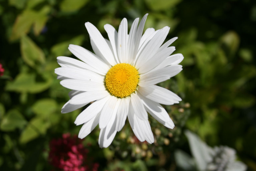

In [4]:
dest = 'daisy.jpg'
download_url(urls[4], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'rose photos'


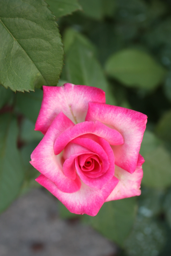

In [5]:
download_url(search_images('rose photos', max_images=5)[1], 'rose.jpg', show_progress=False)
Image.open('rose.jpg').to_thumb(256,256)

In [7]:
searches = 'daisy','rose', "tulip", "sunflower", "gerberas"
path = Path('cuzu')


for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'daisy photo'
Searching for 'rose photo'
Searching for 'tulip photo'
Searching for 'sunflower photo'
Searching for 'gerberas photo'


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

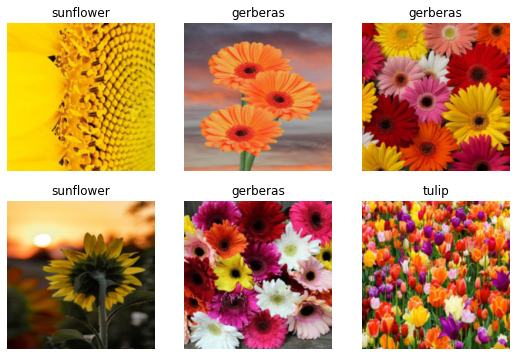

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.310103,1.141298,0.361702,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.897001,0.590206,0.170213,00:01
1,0.659980,0.417903,0.127660,00:01
2,0.461874,0.412454,0.106383,00:01
3,0.342569,0.425023,0.106383,00:01
4,0.271222,0.416832,0.106383,00:01


In [11]:
pred, lab ,probs = learn.predict(PILImage.create('daisy.jpg'))
print(f"This is a: {pred}.")
print(f"Probability: {probs[0]:.4f} / {probs[1]:.4f} / {probs[2]:.4f} / {probs[3]:.4f} / {probs[3]:.4f}")

This is a: daisy.
Probability: 0.9999 / 0.0000 / 0.0000 / 0.0001 / 0.0001


In [19]:
pred, lab ,probs = learn.predict(PILImage.create(dls.items[0]))
print(f"This is a: {pred}.")
print(f"Probability: {probs[0]:.4f} / {probs[1]:.4f} / {probs[2]:.4f} / {probs[3]:.4f} / {probs[3]:.4f}")

This is a: tulip.
Probability: 0.0000 / 0.0000 / 0.0000 / 0.0000 / 0.0000


In [20]:
from os import listdir
from os.path import isfile, join
mypath = "/content/cuzu/daisy"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [35]:
falsch = []
for o in searches:
    mypath = f"/content/cuzu/{o}/"
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    anz = 0
    richtig = 0
    for f in onlyfiles:
        anz += 1
        pred, _ ,_ = learn.predict(PILImage.create(mypath + f))
        if pred == o:
            richtig += 1
        else:
            falsch.append([mypath + f, pred])

    print(f'Anteil richtig bei {o}: {richtig/anz:.4f}')




Anteil richtig bei daisy: 0.9111


Anteil richtig bei rose: 0.9592


Anteil richtig bei tulip: 1.0000


Anteil richtig bei sunflower: 1.0000


Anteil richtig bei gerberas: 1.0000


In [36]:
falsch

[['/content/cuzu/daisy/0aa0e9dd-6aaf-4529-9077-7fe4cd187885.jpg', 'sunflower'],
 ['/content/cuzu/daisy/0fdf48da-f78b-4452-b1f0-8c40a2e75541.jpg', 'gerberas'],
 ['/content/cuzu/daisy/e3ebb373-04cf-4fa9-9ab3-c01fc68cf720.jpg', 'gerberas'],
 ['/content/cuzu/daisy/b93b6ac8-3a60-4e9e-bd66-0676c6b3c8d2.jpg', 'sunflower'],
 ['/content/cuzu/rose/ec3ad66a-d3ad-45d3-b963-f2a981c6915a.jpg', 'tulip'],
 ['/content/cuzu/rose/75b1700a-1e1e-44f9-8654-5907a4c9ebeb.jpg', 'tulip']]

tulip


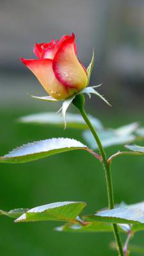

In [44]:
i = 5
print(falsch[i][1])
Image.open(falsch[i][0]).to_thumb(256,256)